In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, extensions
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit_experiments.library import T2Ramsey
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Hamiltonian describes the situation in a physical system. For the sensing application we choose a Hamiltonian, $H= \sigma_{z}$. We will do the time evolution of our hamiltonian for pi/3 time.

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [-0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
          [-0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
          [ 0.-0.j,  0.-0.j,  0.-0.j,  1.-0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Instruction(name='hamiltonian', num_qubits=2, num_clbits=0, params=[array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
       [-0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
       [ 0.-0.j,  0.-0.j,  0.-0.j,  1.-0.j]]), 1.0471975511965976])


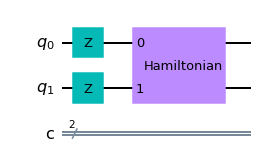

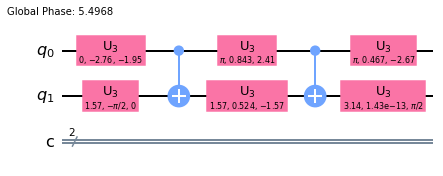

/tmp/ipykernel_59/1225546744.py:30: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  bell1 = bell+circ


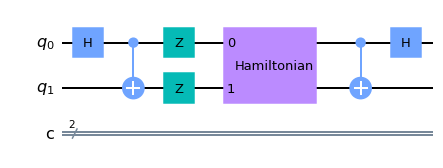

{'00 00': 1024}
     ┌───┐┌─────────────────┐┌──────────┐ ░ ┌───┐ ░ ┌─┐
  q: ┤ H ├┤ Delay(3e-06[s]) ├┤ Rz(3π/5) ├─░─┤ H ├─░─┤M├
     └───┘└─────────────────┘└──────────┘ ░ └───┘ ░ └╥┘
c: 1/════════════════════════════════════════════════╩═
                                                     0 
     ┌───┐┌─────────────────┐┌──────────┐ ░ ┌───┐ ░ ┌─┐
  q: ┤ H ├┤ Delay(3e-06[s]) ├┤ Rz(3π/5) ├─░─┤ H ├─░─┤M├
     └───┘└─────────────────┘└──────────┘ ░ └───┘ ░ └╥┘
c: 1/════════════════════════════════════════════════╩═
                                                     0 


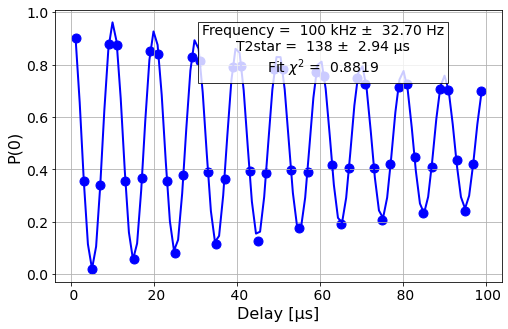

In [2]:
circ = QuantumCircuit(2,2)
bell = QuantumCircuit(2,2)
#circ.h(0)
#circ.cx(0,1)
def matrix(qc):
    backend = Aer.get_backend('unitary_simulator')
    job =  execute(qc, backend)
    result = job.result()
    return result
circ.z(0)
circ.z(1)
mat = matrix(circ).get_unitary(circ, decimals= 3)
print(mat)
def hamilton(operator, time):
    gate = extensions.HamiltonianGate(operator, time)
    return gate

evolution = hamilton(mat, np.pi/3)
print(evolution)
#ham_gate = QuantumCircuit(2)
#ham_gate.unitary(evolution, [0,1])
#circuit = QuantumCircuit(2,2)
circ.append(evolution, [0, 1])
display(circ.draw())

tran_ham = transpile(circ, basis_gates=['cx','u3'])
display(tran_ham.draw())
bell.h(0)
bell.cx(0,1)
bell1 = bell+circ
bell1.cx(0,1)
bell1.h(0)
display(bell1.draw())
bell1.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(bell1, backend, shots = 1024)
result_sim = job.result()
counts = result_sim.get_counts(bell1)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

qubit = [0,1]
# set the desired delays
delays = list(np.arange(1e-6, 100e-6, 2e-6))

for i in range(2):
    # Create a T2Ramsey experiment. Print the first circuit as an example
    exp1 = T2Ramsey(qubit[i], delays, osc_freq=1e5)

    print(exp1.circuits()[1])
    

# A T1 simulator
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakeVigo(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakeVigo(), noise_model=noise_model)


# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

Following cell creates a time evolution gate of our sensor hamiltonian